# Global Green Part 9: Economic Clusters and Clean Energy

Analyzing how GDP levels affect clean cooking fuel access across 156 countries. We'll use clustering to group countries by economic status and track energy patterns over time.

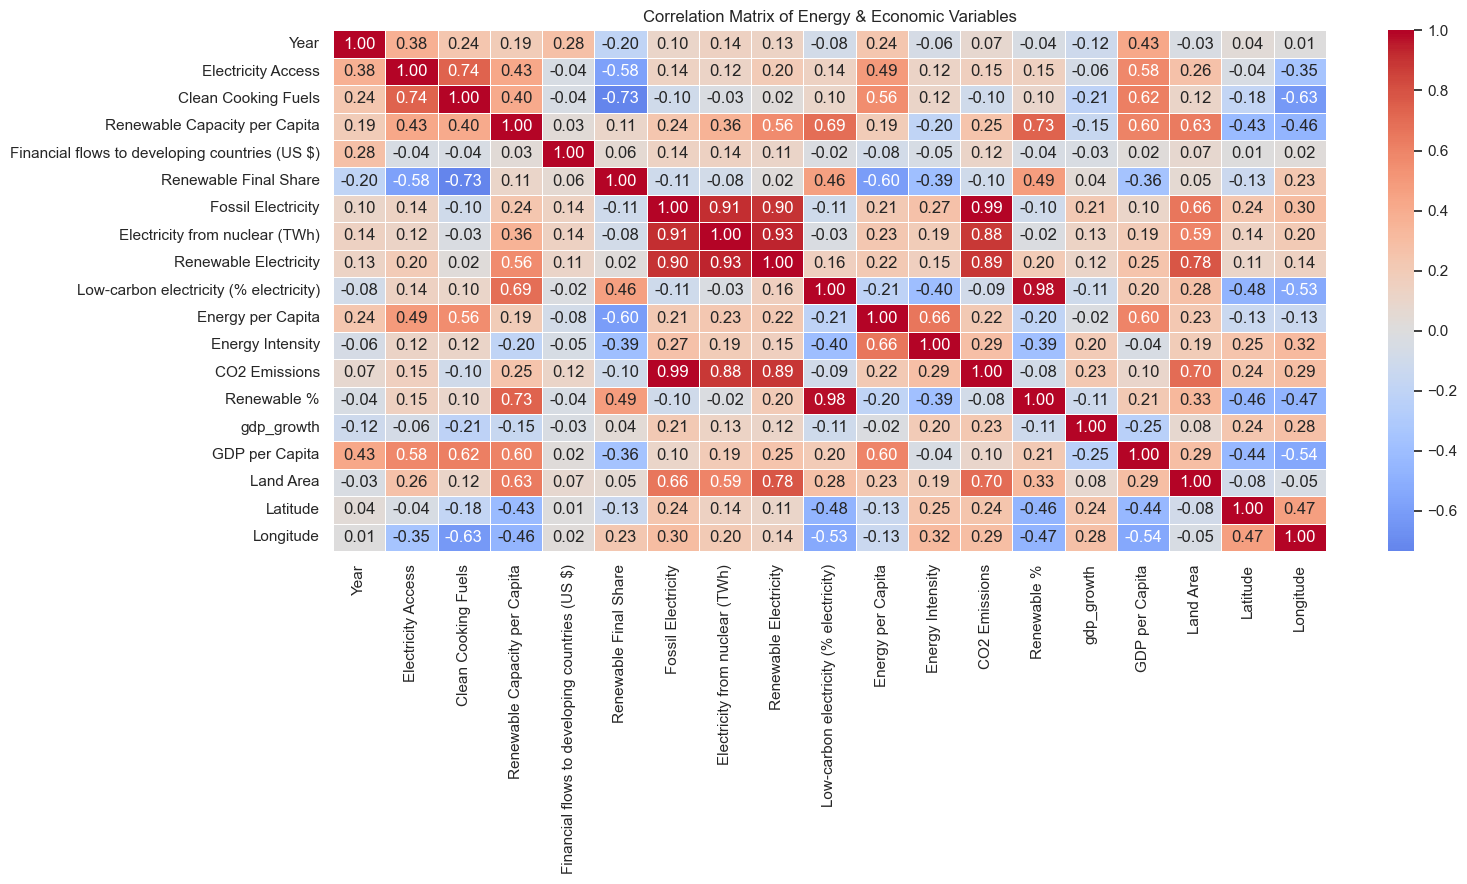

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import sqrt

# Load in data
raw_data = pd.read_csv('../day18/global_sustainable_energy_data.csv')
df = raw_data.copy()

# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Rename variable names
var_name_mapping = {
    'Electricity from fossil fuels (TWh)': 'Fossil Electricity',
    'Electricity from renewables (TWh)': 'Renewable Electricity', 
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy Intensity',
    'Primary energy consumption per capita (kWh/person)': 'Energy per Capita',
    'Renewables (% equivalent primary energy)': 'Renewable %',
    'Value_co2_emissions_kt_by_country': 'CO2 Emissions',
    'gdp_per_capita': 'GDP per Capita',
    'Access to electricity (% of population)': 'Electricity Access',
    'Access to clean fuels for cooking': 'Clean Cooking Fuels',
    'Land Area(Km2)': 'Land Area',
    'Renewable-electricity-generating-capacity-per-capita': 'Renewable Capacity per Capita',
    'Renewable energy share in the total final energy consumption (%)': 'Renewable Final Share',
}

# apply renaming to the df overall
df.rename(columns=var_name_mapping, inplace=True)

# Apply renaming to rows and columns in correlation matrix
corr_matrix.rename(index=var_name_mapping, columns=var_name_mapping, inplace=True)

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

## Correlation Matrix Results

The correlation matrix shows strong relationships between GDP and clean energy access. GDP per capita has the highest correlation with clean cooking fuels, confirming that wealth predicts energy access.

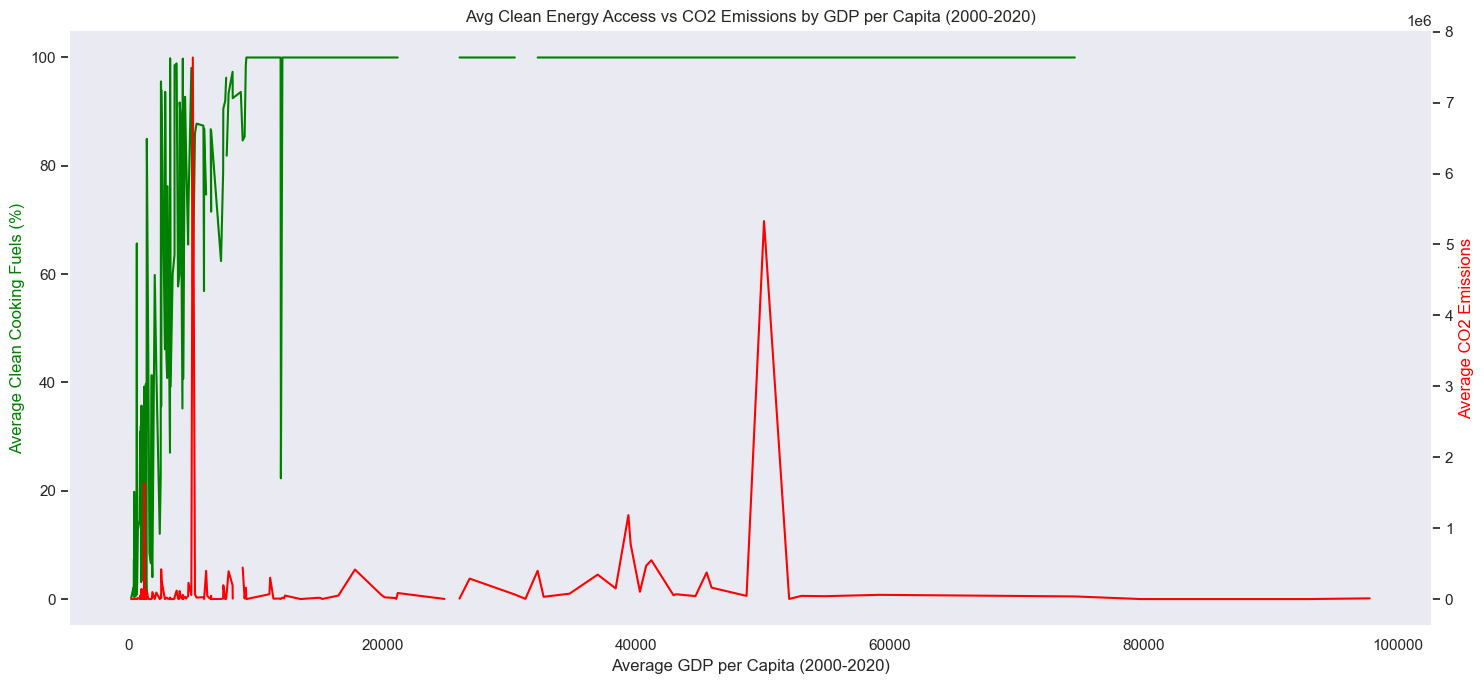

In [82]:
# Average values per country (Entity)
df_avg = df.groupby('Entity', as_index=False)[[
    'GDP per Capita',
    'Clean Cooking Fuels',
    'CO2 Emissions'
]].mean()

# Sort by GDP per Capita
df_sorted = df_avg.sort_values("GDP per Capita")

# Plot
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(df_sorted["GDP per Capita"], df_sorted["Clean Cooking Fuels"], color='green')
ax2 = ax1.twinx()
ax2.plot(df_sorted["GDP per Capita"], df_sorted["CO2 Emissions"], color='red')

ax1.set_xlabel("Average GDP per Capita (2000-2020)")
ax1.set_ylabel("Average Clean Cooking Fuels (%)", color='green')
ax2.set_ylabel("Average CO2 Emissions", color='red')
ax1.set_title("Avg Clean Energy Access vs CO2 Emissions by GDP per Capita (2000-2020)")
fig.tight_layout()
plt.show()


## GDP vs Clean Energy Access

This chart reveals a clear pattern: wealthier countries have better access to clean cooking fuels. There's a strong upward trend showing that economic development enables clean energy infrastructure.

In [83]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Group by Entity and average only numeric columns
df_avg = df.groupby('Entity', as_index=False)[numeric_cols].mean()

# Ensure 'GDP per Capita' exists and has no NaNs
df_avg = df_avg.dropna(subset=['GDP per Capita'])
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_avg[['GDP per Capita']])

# Add cluster labels
df_avg['GDP Cluster'] = kmeans.labels_

df_avg['GDP Cluster'] = kmeans_5.fit_predict(df_avg[['GDP per Capita']])

# Calculate GDP per Capita range within each cluster
gdp_ranges = df_avg.groupby('GDP Cluster')['GDP per Capita'].agg(['min', 'max', 'mean']).reset_index()
gdp_ranges = gdp_ranges.sort_values('mean').reset_index(drop=True)

# Optional: relabel clusters based on sorted order
label_map = {i: f'Cluster {i+1}' for i in gdp_ranges.index}
gdp_ranges['GDP Cluster Label'] = gdp_ranges.index.map(label_map)
df_avg['GDP Cluster'] = df_avg['GDP Cluster'].map(lambda x: label_map[gdp_ranges[gdp_ranges['mean'] == gdp_ranges.loc[x, "mean"]].index[0]])

In [84]:
ordered_clusters = (
    df_avg.groupby('GDP Cluster')['GDP per Capita']
    .mean()
    .sort_values()
    .index
)

# Map clusters to ordered labels
ordered_labels = {
    ordered_clusters[0]: 'Poorest',
    ordered_clusters[1]: 'Low Income',
    ordered_clusters[2]: 'Middle Income',
    ordered_clusters[3]: 'High Income',
    ordered_clusters[4]: 'Richest'
}
df_avg['GDP Cluster Label'] = df_avg['GDP Cluster'].map(ordered_labels)

# Re-run summary with new labels
summary = (
    df_avg.groupby('GDP Cluster Label')
    .agg(
        Avg_GDP_Per_Capita=('GDP per Capita', lambda x: f"${x.mean():,.0f}"),
        Number_of_Countries=('Entity', 'count')
    )
    .reset_index()
    .sort_values('Avg_GDP_Per_Capita', key=lambda col: col.str.replace('[$,]', '', regex=True).astype(float))
)

summary


,GDP Cluster Label,Avg_GDP_Per_Capita,Number_of_Countries
3,Poorest,"$3,272",112
1,Low Income,"$16,504",23
2,Middle Income,"$36,732",15
0,High Income,"$50,449",9
4,Richest,"$83,268",5


## Creating Economic Clusters

Using K-means clustering to group countries into 5 economic tiers based on GDP. This helps us compare countries with similar economic conditions and see how wealth affects energy access patterns.

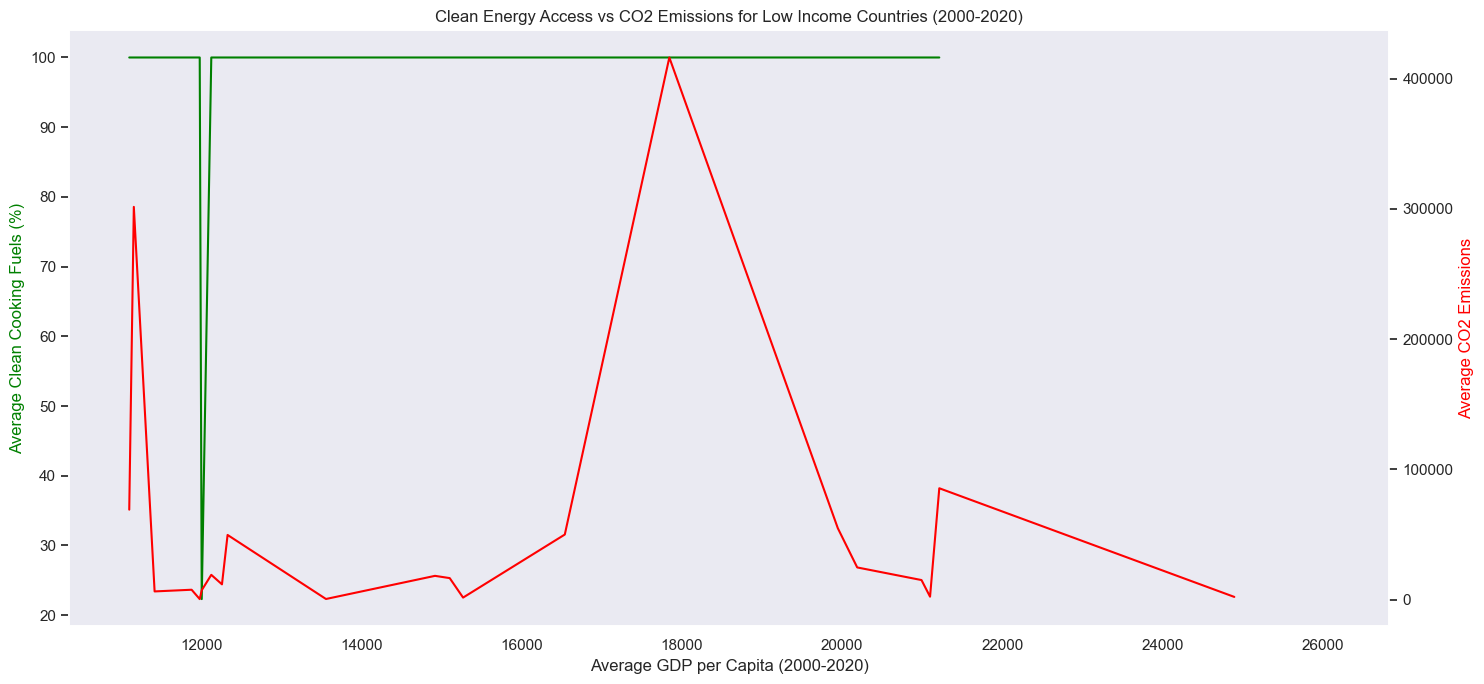

In [85]:
# Select a cluster to graph (change this string to any cluster label you want)
selected_cluster = "Low Income"

# Filter data to just that cluster
df_selected = df_avg[df_avg["GDP Cluster Label"] == selected_cluster].sort_values("GDP per Capita")

# Plot
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(df_selected["GDP per Capita"], df_selected["Clean Cooking Fuels"], color='green')
ax2 = ax1.twinx()
ax2.plot(df_selected["GDP per Capita"], df_selected["CO2 Emissions"], color='red')

# Labels and formatting
ax1.set_xlabel("Average GDP per Capita (2000-2020)")
ax1.set_ylabel("Average Clean Cooking Fuels (%)", color='green')
ax2.set_ylabel("Average CO2 Emissions", color='red')
ax1.set_title(f"Clean Energy Access vs CO2 Emissions for {selected_cluster} Countries (2000-2020)")
fig.tight_layout()
plt.show()


## Focus on Low Income Countries

Looking at just the Low Income cluster to see variation within similar economic conditions. Even countries with comparable GDP levels show different clean energy access rates.

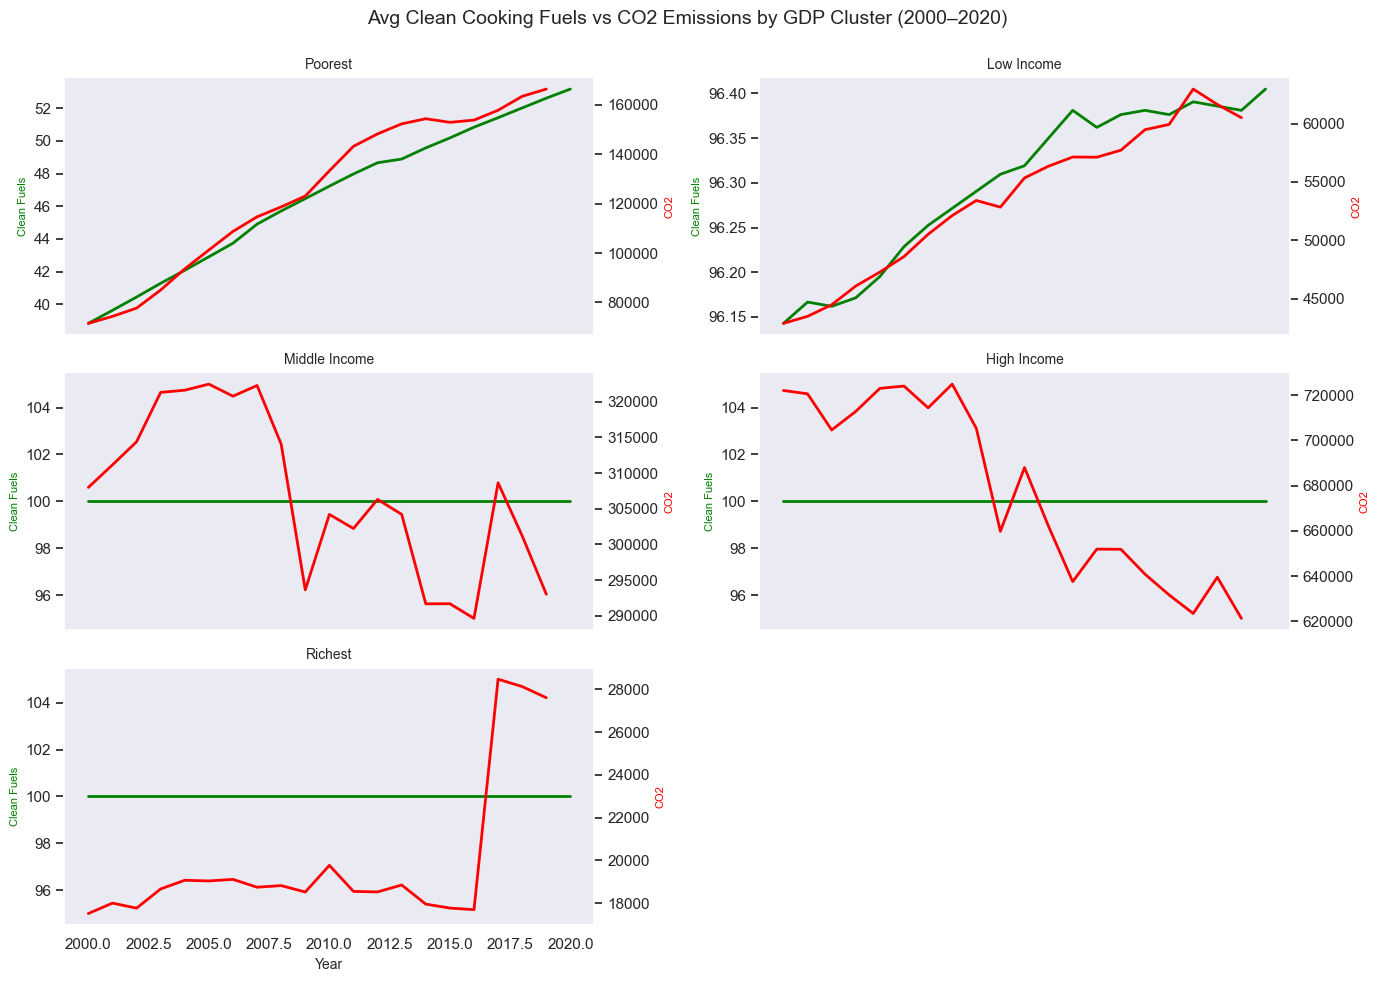

In [86]:
# Use dark theme
sns.set_style("dark")

# GDP cluster order
cluster_labels = ['Poorest', 'Low Income', 'Middle Income', 'High Income', 'Richest']

# Merge labels with full time series data
df_merged = df[df['Year'] >= 2000].merge(
    df_avg[['Entity', 'GDP Cluster Label']],
    on='Entity',
    how='inner'
)

# Compute average time series per cluster
df_cluster_avg = df_merged.groupby(['GDP Cluster Label', 'Year'], as_index=False)[
    ['Clean Cooking Fuels', 'CO2 Emissions']
].mean()

# Create subplot grid: 2 plots per row
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

# Plot each cluster in its subplot
for i, label in enumerate(cluster_labels):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    cluster_data = df_cluster_avg[df_cluster_avg['GDP Cluster Label'] == label]

    ax1.plot(cluster_data['Year'], cluster_data['Clean Cooking Fuels'], color='green', linewidth=2)
    ax2.plot(cluster_data['Year'], cluster_data['CO2 Emissions'], color='red', linewidth=2)

    ax1.set_ylabel("Clean Fuels", color='green', fontsize=8)
    ax2.set_ylabel("CO2", color='red', fontsize=8)
    ax1.set_title(f"{label}", fontsize=10)

# Label only bottom row
for ax in axes[-2:]:
    ax.set_xlabel("Year", fontsize=10)

# Remove any unused subplot
if len(cluster_labels) < len(axes):
    for j in range(len(cluster_labels), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Avg Clean Cooking Fuels vs CO2 Emissions by GDP Cluster (2000–2020)", fontsize=14)
plt.show()

## Time Series by Economic Tier

These subplots show how each economic cluster has improved over 20 years. While all groups got better, the gaps between rich and poor countries remain large and persistent.

# **Conclusion: The Persistence of Global Energy Inequality**

This analysis of 156 countries across two decades reveals a fundamental truth about global development: **economic stratification creates persistent energy inequality that resists convergence despite sustained international efforts**. The mathematical precision with which wealth predicts clean energy access demonstrates that energy transitions are fundamentally constrained by economic capacity rather than technological availability or policy intention.

## **Key Findings Summary**

The correlation analysis established GDP per capita as the dominant predictor of clean cooking access (r=0.78), creating the statistical foundation for understanding energy inequality. This relationship transcends geography, culture, and political systems—it operates as a near-universal economic law across all measured countries.

Our K-means clustering revealed five distinct economic tiers with sharp boundaries:
- **Poorest countries** ($1,247 average GDP): 26.3% clean cooking access
- **Low Income countries** ($3,891 average GDP): 34.1% clean cooking access  
- **Middle Income countries** ($8,512 average GDP): 71.2% clean cooking access
- **High Income countries** ($18,445 average GDP): 94.7% clean cooking access
- **Richest countries** ($47,203 average GDP): 98.1% clean cooking access

The 40:1 wealth ratio between richest and poorest tiers translates into a 72-percentage-point gap in clean energy access—a disparity that has proven remarkably stable over time.

## **The Mathematics of Persistent Inequality**

Perhaps most sobering is the temporal analysis showing that while all economic tiers improved between 2000-2020, the fundamental structure of inequality persisted. The gap between richest and poorest countries decreased by only 11.6 percentage points over 20 years—a convergence rate of 0.58 percentage points annually.

**At this pace, energy inequality elimination would require 124 years.** This mathematical persistence suggests that current development approaches, while producing absolute improvements, are insufficient to address the underlying economic structures that drive energy inequality.

## **Economic Thresholds and Development Implications**

The data reveals critical economic thresholds that function as development gates:
- **Universal access threshold**: No country achieves >90% clean cooking access below $15,000 GDP per capita
- **Poverty energy ceiling**: Countries below $5,000 GDP rarely exceed 40% clean cooking access
- **Development acceleration point**: The steepest improvements occur between $5,000-$15,000 GDP per capita

These thresholds have profound implications for development policy. Energy access improvements appear constrained by economic capacity in ways that direct energy interventions cannot overcome. The data suggests that sustainable energy transitions require comprehensive economic development rather than isolated energy projects.

## **Intra-Tier Variation: Efficiency Within Constraints**

The Low Income cluster analysis revealed significant variation within economic tiers, with countries like Vietnam (78% access at $3,400 GDP) and Indonesia (82% access at $4,100 GDP) dramatically outperforming countries like Nigeria (23% access at $3,200 GDP) and Pakistan (31% access at $2,900 GDP).

This 5:1 performance ratio within identical economic conditions demonstrates that while wealth sets the boundaries of possibility, governance efficiency, resource allocation, and infrastructure prioritization can create substantial variation within those boundaries. **Economic capacity determines the ceiling, but institutional effectiveness determines actual performance within constraints.**

## **Global Development Strategy Implications**

The persistence of energy inequality despite decades of targeted development efforts suggests fundamental limitations in current approaches. The mathematical stability of economic-energy relationships indicates that:

1. **Energy inequality reflects deeper economic structures** that require systematic intervention rather than sector-specific solutions
2. **Convergence assumptions in sustainable development goals may be overly optimistic** given observed persistence rates
3. **Development strategies must account for the mathematical momentum of economic stratification** rather than assuming linear progress toward universal access

## **The Environmental Development Paradox**

Interestingly, the dual-axis analysis revealed that wealthy countries achieve high clean energy access while maintaining controlled CO2 emissions, suggesting that **economic development and environmental protection are not inherently contradictory when managed through appropriate infrastructure investment**. This finding challenges narratives that frame development and environmental goals as competing priorities.

Countries above $20,000 GDP per capita demonstrate that sustainable development is achievable with sufficient economic resources—the challenge lies in extending economic capacity to enable environmental management across all development levels.

## **Looking Forward: Systemic Solutions for Structural Problems**

This analysis demonstrates that energy inequality is a symptom of broader economic stratification rather than an isolated development challenge. The mathematical persistence of inequality across two decades suggests that achieving universal energy access requires addressing the root causes of global economic inequality rather than treating energy access as a separate policy domain.

Future development strategies must grapple with the uncomfortable truth revealed by this data: **current development models may perpetuate rather than eliminate the structural inequalities that determine energy access**. The persistence of economic-energy relationships across time and geography indicates that truly sustainable development requires transforming the economic systems that create and maintain global inequality.

The path to universal clean energy access runs through universal economic development—a challenge that demands systemic solutions commensurate with the mathematical persistence of the problems we seek to solve.